## 도구 호출 에이전트(Tool Calling Agent)

도구 호출을 사용하면 모델이 하나 이상의 도구(tool)가 호출되어야하는 시기를 감지하고 해당 도구에 전달해야 하는 입력으로 전달할 수 있다.

API호출에서 도구를 설명하고 모델이 이러한 도구를 호출하기 위한 인수가 포함된 Json 과 같은 구조화된 객체를 출력하도록 지능적으로 선택이 가능하다.

- 도구 API의 목표 : 일반 텍슽트 완성이나 채팅 API를 사용하여 수행할수 있는 것보다 더 안정적으로 유효하고 유용한 도구 호출 (tool call)을 반환.

이렇게 구조화된 출력을 도구 호출 채팅 모델에 여러 도구를 바인딩하고 모델이 호출할 도구를 선택할 수 있다는 사실과 결합하여 쿼리가 해결될 때까지 반복적으로 도구를 호출하고 결과를 수신하는 에이전트를 만들 수 있다.

이것이 OpenAI의 특정도구 호출 스타일에 맞게 설계된 OpenAI 도구 에이전트의 보다 **일반화된 버전** 이다.

이 Agent는 Langchain의 ToolCall 인터페이스를 사용하여 OpenAI외에도 Anthropic, Google, Gemini, Mistral과 같은 더 광범위한 공급자 구현을 지원한다. 


Source : https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/

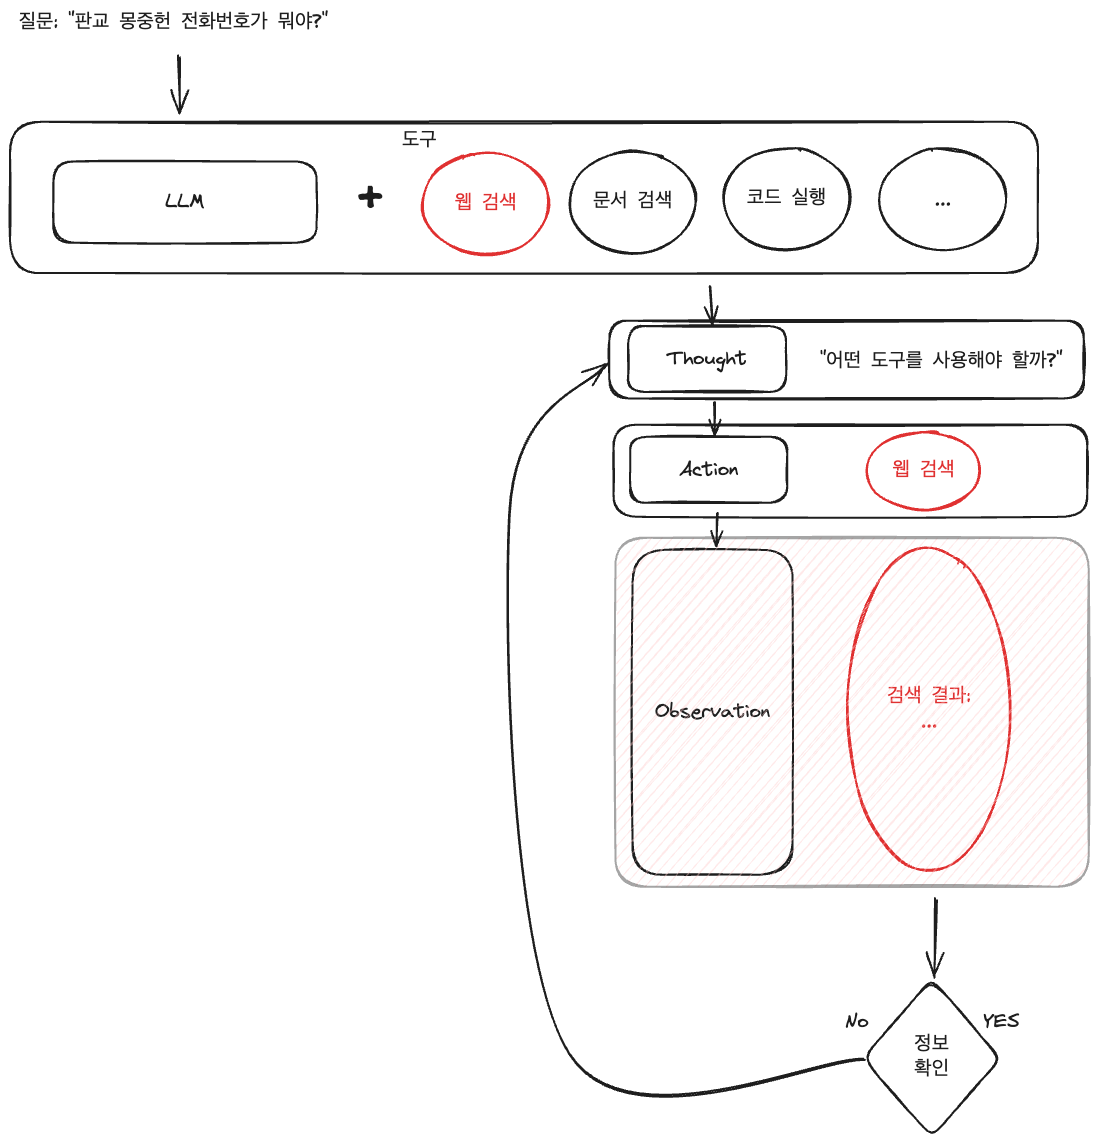

chat_history : 모델이 이전 대화 기록을 기억하는 것.
agent_scratchpad : 에이전트는 검색한다면 검색 결과를 기억하기 위해 agent_scratchpad에 적는다. 사람의 메모장과 같은 개념. 

AgentExecutor : 에이전트를 실행하는 역할. 
    - Agent가 올바르게 실행될 수 있도록 도구를 호출하고 결과를 파싱하는 모든 과정을 자동으로 처리한다.
    - 최대 반복횟수 설정 및 최대 반복횟수 초과시 종료 옵션  등의 기능을 제공한다.


In [1]:
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
# Langsmith 추적설정 
from langchain_teddynote import logging
logging.langsmith("agent-tools")

LangSmith 추적을 시작합니다.
[프로젝트명]
agent-tools


In [3]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL

# create tools
@tool
def search_google_news(query:str) -> str:
    """Serach Google news by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

@tool
def python_repl_tool(
    # Annotated : 타입 힌트를 제공하는 데 사용되는 파이썬 표준 라이브러리 모듈
    code: Annotated[str, "The Python code to execute to generate your chart"]
) :
    """ Use this to execute python code. If you want to see the output of a value, 
    you should print it out with `print(...)`. This is visible to the user"""

    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute code: {e}")
    finally:
        return result 
    
print(f"- Tool Name : {search_google_news.name}")
print(f"- Tool Description : {search_google_news.description}")
print(f"- Tool Name : {python_repl_tool.name}")
print(f"- Tool Description : {python_repl_tool.description}")



- Tool Name : search_google_news
- Tool Description : Serach Google news by input keyword
- Tool Name : python_repl_tool
- Tool Description : Use this to execute python code. If you want to see the output of a value, 
   you should print it out with `print(...)`. This is visible to the user


In [4]:
# Define tools
tools = [search_google_news, python_repl_tool]

### Agent 프롬프트 생성

- `chat_history` : 모델이 이전 대화 기록을 기억하는 것.
- `agent_scratchpad` : 에이전트는 검색 이 후, 그것을 기억하기 위해 agent_scratchpad에 일시적으로 저장한다. 사람의 메모장과 같은 개념. 
- `input` : 사용자의 입력 

In [5]:
from langchain_core.prompts import ChatPromptTemplate

# create prompt
# 프롬프트는 agent에게 모델이 수행할 작업을 설명하는 텍스트를 제공한다.(도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "you are a helpful assistant."
     "Make sure to use the `search_news` tool for searching keyword related news."
     ),
     ("placeholder", "{chat_history}"),
     ("human", "{input}"),
     ("placeholder", "{agent_scratchpad}"),
])

### Agent 생성

In [13]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# define agent
llm = ChatOpenAI(model="gpt-4o", temperature=0)

#create agent
agent = create_tool_calling_agent(llm, tools, prompt)

### AgentExecutor

AgentExecutor는 에이전트를 실행하는 클래스 이다.

#### AgentExecutor Elements
- `agent` : 실행루프 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools` : 에이전트가 사용할 수 있는 도구 목록
- `return_intermediate_steps` : 최종 출력과 함께 에이전트의 중간 단계 경로를 반환할지의 여부
- `max_iterations` : 최대 반복 횟수
- `max_execution_time` : 최대 실행 시간
- `early_stopping_method` : agent가 `AgentFinish`를 반환하지 않을때 사용할 조기 종료 방법. ("generate" or "force")
    - `generate` : Agent의 LLM 체인을 마지막으로 한번 호출하여 이전 단계에 따라 최종 답변 생성
    - `force` : 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환
- `handle_parsing_errors` : 파싱 오류가 발생할 경우 처리하는 함수(True or False or 오류 처리함수)
- `trim_intermediate_steps` : 중간 단계를 trimming 하는 방법 (-1 trim 하지 않음, 또는 트리밍 함수)

#### 주요 메서드
- `invoke` : 입력을 받아 에이전트를 실행
- `stream` : 최종 출력에 도달하는데 필요한 단계를 스트리밍

#### 주요 기능
1. 도구 검증 : 에이전트와 호환되는 도구인지 확인
2. 실행 제어 : 최대 반복횟수 및 실행 시간 제한 설정
3. 오류처리 : 출력 파싱 오류에 대한 다양한 처리 옵션
4. 중간 단계 관리 : 중간 단계 트리밍 및 반환 옵션
5. 비동기 지원 : 비동기 실행 및 스트리밍 지원

#### 최적화
- `max_iterations` 과 `max_execution_time` 설정을 통해 실행 시간 관리
- `trim_intermediate_steps` 를 사용하여 중간 단계 트리밍하므로서 메모리 사용량 최적화
- 복잡한 작업의 경우 `stream` 메서드를 사용하여 단계별 결과 모니터링

In [14]:
from langchain.agents import AgentExecutor

# create AgentExecutor 
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
    # trim_intermediate_steps=-1,
)

# run executor
result = agent_executor.invoke({"input": "AI 투자 관련 뉴스를 검색해주세요"})

print("Agent Executor Result : \n", result)




> Entering new AgentExecutor chain...

Invoking: `search_google_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiW0FVX3lxTE4zbUlUMW5PZ2xBWVBXQjRrdWM1ZlRlN3BoWE1VRkd3cHRlcTVKSEEtLUZrMWlKc2NkRFY5dmJ3YmlmUTctd2Q4SzNxQnJBZnJMYzJxOVo1WjB1em_SAV5BVV95cUxQWjVzN2t0ejY2akhjZGVGbnpRRWw3ZWUwckFLc3U3NXkwaFcxaTVCRWJHY0M0STNhMU1heURwWmlXa285YnJqa2h5NFdkamVEejhwQnpVNE9uVS1aWk9B?oc=5', 'content': '트럼프발 AI 투자, 한국기업에 기회?…"전력 설루션 시장 주목" - 연합뉴스'}, {'url': 'https://news.google.com/rss/articles/CBMiXEFVX3lxTFBDQUw1SzE3c1ZWcVM4RUMxTy1IbmlUdzQ3UW1hQ1Fzc01mbXM5M0d0TlNwMC1hUmR3cWZiRDU3ZGwwWFY0b3c2MGliSmlVVEotUlQ0UVFaampRUTFK?oc=5', 'content': 'ETF·AI 투자의 새 물결… 금리 하락기의 전략적 자산 배분 가이드 [AI PRISM*주간 금융상품 투자자 뉴스] - 서울경제신문'}, {'url': 'https://news.google.com/rss/articles/CBMiWEFVX3lxTE5IYk80R1pzV084dlpXODE3ZWRLTGFhZ0NaWmJoTGRIVE00OWwzcVBTTElUanJjRmtDMmVZV20xUkVoaEVFRnVxYTV1VFJ4T1B2dkxMM1cwUDQ?oc=5', 'content': 'AI 투자 적게 했다는 이유로 애플은 3% 급등, 시총 1위 탈환 - 뉴스1'}, {'url': 'https://news.go

위 결과와 같이 "AI 투자 관련 뉴스를 검색해주세요"라는 질문에 키워드 "AI 투자"를 생성하여 검색하고, 
"'다음은 AI 투자와 관련된 최근 뉴스입니다:..... (검색된뉴스)" 
라는 메시지와 함께 검색된 뉴스를 출력한다.

## Stream 출력으로 단계별 결과 확인

AgentExecutor의 `stream()` 메서드를 사용하여 에이전트의 중간 단계를 스트리밍.

`stream()`의 출력은 (Action, Observation) 쌍의 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리된다.

답변은 다음과 같은 형태로 보인다.
1. **Action** 출력 : 에이전트가 수행할 동작을 나타내는 문자열
2. **Observation** 출력 : 동작의 결과를 나타내는 문자열
3. **Action** 출력 : 에이전트가 수행할 동작을 나타내는 문자열
4. **Observation** 출력 : 동작의 결과를 나타내는 문자열

...(목표 달성까지 계속)

...
5. **최종답변** : 목표 달성 후 최종 답변

이러한 출력의 내용은 다음과 같이 요약할 수 있다.

| 출력 | 내용 |
| --- | --- |
| Action | `actions` : AgentAction 또는 그의 하위 클래스<br> `messages` : 액현 호출에 해당하는 채팅 메세지|
| Observation | `steps` : 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 기록 <br> `messages` : 함수 호출 결과 (즉, 관찰)를 포함한 채팅 메시지 |
| Final Answer | `output` : AgentFinish<br>`messages` : 최종 출력을 포함한 채팅 메세지 |




In [15]:
from langchain.agents import AgentExecutor

# create AgentExecutor
agent_executor = AgentExecutor(
    agent = agent,
    tools = tools,
    verbose = False,
    handle_parsing_errors = True,
)

In [9]:
# execute with stream mode
result = agent_executor.stream({"input" : "AI 투자 관련 뉴스를 검색해주세요"})

for step in result :
    # 중간 단계 출력
    print(step)
    print("---"*20)



{'actions': [ToolAgentAction(tool='search_google_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_google_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_RTRyUTtL3RORNO2xqWkcfJw1', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_google_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63'}, id='run-27797c35-d0df-4c51-a09a-969582121fc3', tool_calls=[{'name': 'search_google_news', 'args': {'query': 'AI 투자'}, 'id': 'call_RTRyUTtL3RORNO2xqWkcfJw1', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_google_news', 'args': '{"query":"AI 투자"}', 'id': 'call_RTRyUTtL3RORNO2xqWkcfJw1', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_RTRyUTtL3RORNO2xqWkcfJw1')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'ca

### 중간단계 출력을 사용자 정의 함수로 출력

다음의 3개 함수를 정의하고 이를 통해 중간 단계 출력을 사용자 정의.

- `tool_callback` : 도구 호출 결과를 출력하는 함수
- `observation_callback` : 관찰 결과를 출력하는 함수
- `result_callback` : 최종 결과를 출력하는 함수

아래는 Agent의 중간 단계 과정을 깔끔하게 출력하기 위해 유튜버 강사 테디노트님이 만들어 제공하는 콜백 함수이다.

이 콜백 함수는 Streamlit 에서 중간 단계를 출력하여 사용자에게 제공할 때 유용할 것이라 한다.

In [16]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

스트리밍 방식으로 Agent의 응답 과정을 확인한다.

[도구 호출]
Tool: python_repl_tool
code: # First, let's install the matplotlib module
!pip install matplotlib
Log: 
Invoking: `python_repl_tool` with `{'code': "# First, let's install the matplotlib module\n!pip install matplotlib"}`



[관찰 내용]
Observation: SyntaxError('invalid syntax', ('<string>', 2, 1, '!pip install matplotlib\n', 2, 2))
[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터 준비
labels = ['Python', 'Java', 'JavaScript', 'C++']
sizes = [30, 25, 25, 20]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # Python 부분을 강조

# 파이 차트 그리기
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# 차트가 원형으로 보이도록 설정
plt.axis('equal')

# 차트 보여주기
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터 준비\nlabels = ['Python', 'Java', 'JavaScript', 'C++']\nsizes = [30, 25, 25, 20]\ncolors = ['gold', 'yellowgreen', 'lightcoral', '

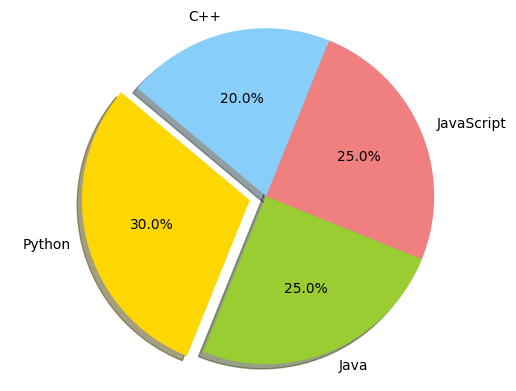

[관찰 내용]
Observation: 
[최종 답변]
위의 코드를 실행하여 파이 차트를 성공적으로 그렸습니다. 차트는 각 프로그래밍 언어의 비율을 시각적으로 보여줍니다. `Python` 부분은 강조되어 있으며, 각 섹션은 해당 언어의 비율을 퍼센트로 표시합니다.


In [21]:
# 질의에 대한 답변을 스트리밍으로 출력
result = agent_executor.stream(
    {"input" : "matplotlib 모듈을 설치하고 이를 사용하여 pie 차트를 그리는 코드를 작성하고 실행하여 차트를 그려주세요. "}
    )

for step in result :
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

In [40]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("------------------ 도구 호출 ------------------")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("---------------------------------------------")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("------------------ 관찰 내용 ------------------")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("---------------------------------------------")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("------------------ 최종 답변 ------------------")
    print(result)  # 최종 답변을 출력합니다.
    print("---------------------------------------------")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback, # `tool_callback` : 도구 호출 결과를 출력하는 함수
    observation_callback=observation_callback, # `observation_callback` : 관찰 결과를 출력하는 함수
    result_callback=result_callback, # `result_callback` : 최종 결과를 출력하는 함수
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

아래의 출력 내용을 확인 해보면 중간 내용의 출력 값과 내가 변경한 콟백 함수의 출력 값으로 변경된 것을 확인할 수 있다.

In [41]:
# 질의 에 대한 답변을 스트리밍으로 출력
result = agent_executor.stream(
    {"input" : "대한민국 정치 관련 최신 뉴스를 검색해주세요."}
    )

for step in result :
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

--------- 도구 호출 ---------
Tool: search_google_news
---------------------------
--------- 관찰 내용 ---------
Observation: {'url': 'https://news.google.com/rss/articles/CBMiYEFVX3lxTE1ISzZUUnhzZ2FVZGtZT3drTHQxd1E4bnN2TVlrdU9kTGF6SzVuSnJ4QVkza3diaGN4OUlGS2czdWV6U01yZU5wU0VFZWlfMTg5eWREMUlnSjFOWG9UaV9tU9IBeEFVX3lxTE1KTU80b3QtSmE5djMyTUhaMkowRnhrYTJWUHU5VGc0Mkl5N0NXSG9SM29WVVByWHNuRzhncDk2MVViV0J1RjRZSEFzSEVGNFRVNzZyYlZET2VJVXdGQXpCTERoeEQycWpNRlZRdEZJLUxNU3VId01UYg?oc=5', 'content': '이준석 "尹 부정선거론 국격 망가뜨려…이미 대법원서 논란 정리" - 뉴시스'}
---------------------------
--------- 최종 답변 ---------
다음은 대한민국 정치 관련 최신 뉴스입니다:

1. [이준석 "尹 부정선거론 국격 망가뜨려…이미 대법원서 논란 정리"](https://news.google.com/rss/articles/CBMiYEFVX3lxTE1ISzZUUnhzZ2FVZGtZT3drTHQxd1E4bnN2TVlrdU9kTGF6SzVuSnJ4QVkza3diaGN4OUlGS2czdWV6U01yZU5wU0VFZWlfMTg5eWREMUlnSjFOWG9UaV9tU9IBeEFVX3lxTE1KTU80b3QtSmE5djMyTUhaMkowRnhrYTJWUHU5VGc0Mkl5N0NXSG9SM29WVVByWHNuRzhncDk2MVViV0J1RjRZSEFzSEVGNFRVNzZyYlZET2VJVXdGQXpCTERoeEQycWpNRlZRdEZJLUxNU3VId01UYg?oc=5) - 뉴시스

2. [

### 이전 대화 내용을 기억하는 Agent(RunnableWithMessageHistory)

이전 대화 내용을 기억하기 위해 `RunnableWithMessageHistory` 를 사용하여 AgentExecutor 를 감싸주어야한다.
`RunnableWithMessageHistory` 에 대한 자세한 내용은 아래 링크를 참고
Source : https://wikidocs.net/254682

from 

In [26]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv()

logging.langsmith("agent-history")



LangSmith 추적을 시작합니다.
[프로젝트명]
agent-history


In [34]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# session_id 를 저장할 딕셔너리 생성
store = {}

# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store : # session_id가 store에 없으면
        # 새로운 ChatMessageHistory 객체 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids] # 해당 session_id 의 대화 기록을 반환


# 채팅 메시지 기록이 추가된 에이전트 생성
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history, # 대화 session_id 
    input_messages_key="input", # 사용자 입력 메시지 키
    history_messages_key="chat_history", # 프롬프트의 메시지가 입력되는 key 
)

In [35]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input" : "안녕하세요. 저는 김루아입니다."},
    # session_id설정
    config = {"configurable" : {"session_id" : "abc123"}}
)

# 출력 결과 확인
for step in response :
    agent_stream_parser.process_agent_steps(step)

--------- 최종 답변 ---------
안녕하세요, 김루아님! 어떻게 도와드릴까요?
--------- 최종 답변 ---------


In [36]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input" : "내 이름이 뭐라고 했지???"},
    # session_id설정
    config = {"configurable" : {"session_id" : "abc123"}}
)

# 출력 결과 확인
for step in response :
    agent_stream_parser.process_agent_steps(step)

--------- 최종 답변 ---------
당신의 이름은 김루아라고 하셨습니다. 맞나요?
--------- 최종 답변 ---------


In [37]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input" : "내 이메일은 kimhk0315@gmail.com이야."},
    # session_id설정
    config = {"configurable" : {"session_id" : "abc123"}}
)

# 출력 결과 확인
for step in response :
    agent_stream_parser.process_agent_steps(step)

--------- 최종 답변 ---------
알겠습니다, 김루아님. 이메일 주소는 kimhk0315@gmail.com이군요. 다른 도움이 필요하시면 말씀해 주세요!
--------- 최종 답변 ---------


In [38]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input" : "AI 투자 관련 최신 뉴스를 3개 검색해서 이메일의 본문으로 작성해줘."
     "수신인은 `조성우님`이고, 발신인에는 내 인적정보를 적어줘."
     "사랑스러운 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."},
    # session_id설정
    config = {"configurable" : {"session_id" : "abc123"}}
)

# 출력 결과 확인
for step in response :
    agent_stream_parser.process_agent_steps(step)

--------- 도구 호출 ---------
Tool: search_google_news
--------- 도구 호출 ---------
--------- 관찰 내용 ---------
Observation: {'url': 'https://news.google.com/rss/articles/CBMidEFVX3lxTE80UnlOZnJFZXlZUGFfVmJXY2NfSld1dXpHck5jSXQzWUpCdkdFTFRIMFpDY21VeFZ4ckxoa0dDN1BPNkRaSEFULU5MSDhvaDY4eEg0eWJydEpyOFdmb1dpZ3U1amUwMTIyZzZ1aU9JY3ZTeUZi?oc=5', 'content': 'JPMorgan, DeepSeek AI 출시를 잠재적 성장 기회로 봐 By Investing.com - Investing.com'}
--------- 관찰 내용 ---------
--------- 도구 호출 ---------
Tool: python_repl_tool
--------- 도구 호출 ---------
--------- 관찰 내용 ---------
Observation: 

--------- 관찰 내용 ---------
--------- 최종 답변 ---------
여기 이메일 본문을 작성해드렸습니다. 사랑스러운 어조로 작성된 이메일입니다:

---

사랑하는 조성우님께,

안녕하세요! 김루아입니다. 오늘도 행복한 하루 보내고 계신가요? 최근 AI 투자에 관한 흥미로운 소식들을 전해드리고 싶어서 이렇게 메일을 드립니다.

1. JPMorgan, DeepSeek AI 출시를 잠재적 성장 기회로 봐 - Investing.com
   자세한 내용은 [여기](https://news.google.com/rss/articles/CBMidEFVX3lxTE80UnlOZnJFZXlZUGFfVmJXY2NfSld1dXpHck5jSXQzWUpCdkdFTFRIMFpDY21VeFZ4ckxoa0dDN1BPNkRaSEFULU5MSDhvaDY4eEg0eWJydEpyOFdmb1dpZ

In [39]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input" : "내 이름이 뭔지 기억해?"},
    # session_id설정
    config = {"configurable" : {"session_id" : "12345"}}# sesson_id를 바꾸면 새로운 대화창이 시작되어 이전내용은 기억하지 못함.
)

# 출력 결과 확인
for step in response :
    agent_stream_parser.process_agent_steps(step)

--------- 최종 답변 ---------
죄송하지만, 이전 대화의 내용을 기억할 수 없습니다. 그래서 당신의 이름을 알 수 없습니다. 어떻게 도와드릴까요?
--------- 최종 답변 ---------
